In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()

#if device_name != '/device:GPU:0':
#    raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [60]:
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle
import zipfile
import soundfile
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3786842354259324416,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 107261185306810506
 physical_device_desc: "device: XLA_CPU device"]

In [4]:
tf.random.set_seed(999)
np.random.seed(999)

In [ ]:
!wget 'cdn.daitan.com/dataset.zip'

In [ ]:
dataset_file_name = './dataset.zip'
with zipfile.ZipFile(dataset_file_name, 'r') as zip_ref:
    zip_ref.extractall('./dataset')

In [5]:
path_to_dataset = "./records/"

In [6]:
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'val_*'))

# suffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names: ", train_tfrecords_filenames)
print("Validation file names: ", val_tfrecords_filenames)

Training file names:  ['./records/train_0.tfrecords']
Validation file names:  ['./records/val_0.tfrecords']


In [7]:
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [ ]:
mozilla_basepath = "./dataset/en"
UrbanSound8K_basepath = './dataset/UrbanSound8K'

## Prepare Input features

In [8]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude

## Create tf.Data.Dataset

In [17]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(8192)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [18]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(512)

## Model Training

In [19]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [20]:
def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
    x = Activation('relu')(x)
    if use_bn:
        x = BatchNormalization()(x)
    return x

In [21]:
def full_pre_activation_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
    shortcut = x
    in_channels = x.shape[-1]

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=in_channels, kernel_size=kernel_size, strides=strides, padding='same')(x)

    return shortcut + x

In [22]:
def build_model(l2_strength):
    inputs = Input(shape=[numFeatures,numSegments,1])
    x = inputs

    # -----
    x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
    x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip0)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # -----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip1)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip1
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip0
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

    model = Model(inputs=inputs, outputs=x)

    optimizer = tf.keras.optimizers.Adam(3e-4)
    #optimizer = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=3e-4)

    model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
    return model

In [23]:
model = build_model(l2_strength=0.0)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 137, 8, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 129, 1, 18)   1296        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 129, 1, 18)   0           conv2d[0][0]                     
_______________________________________________________________________________________

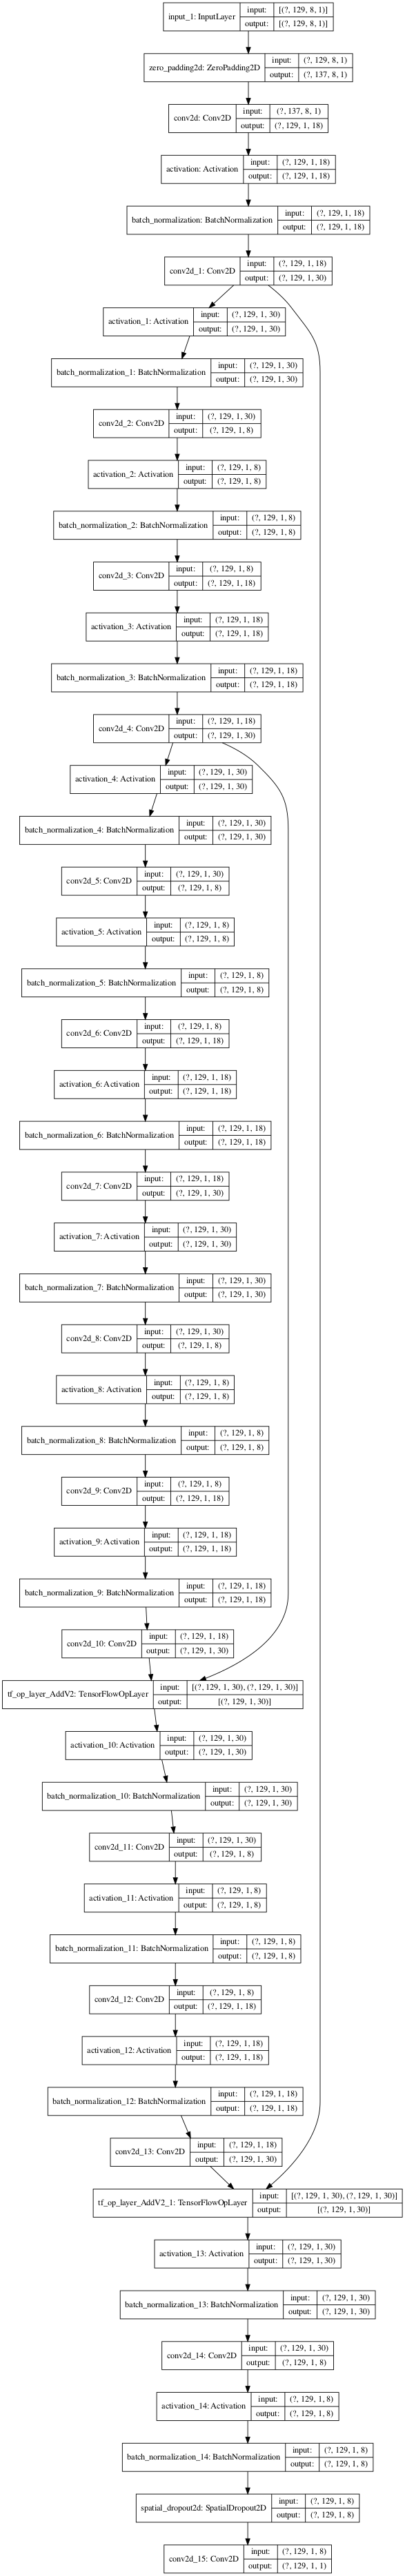

In [24]:
# You might need to install the following dependencies: sudo apt install python-pydot python-pydot-ng graphviz
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [25]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 9290), started 19:09:01 ago. (Use '!kill 9290' to kill it.)

In [26]:
baseline_val_loss = model.evaluate(test_dataset)[0]
print(f"Baseline accuracy {baseline_val_loss}")

18/18 [==============================] - 5s 289ms/step - loss: 0.5454 - rmse: 0.7385
Baseline accuracy 0.5454273223876953


In [27]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised, cleaned, eps=1e-7): # Signal to Distortion Ratio
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [30]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=None)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./denoiser_cnn_log_mel_generator.h5', 
                                                         monitor='val_loss', save_best_only=True)

model.fit(train_dataset,
         steps_per_epoch=60, # you might need to change this
         validation_data=test_dataset,
         epochs=200,
         callbacks=[early_stopping_callback, tensorboard_callback, checkpoint_callback]
        )

Epoch 1/200
60/60 [==============================] - 78s 1s/step - loss: 0.5502 - rmse: 0.7417 - val_loss: 0.4596 - val_rmse: 0.6780
Epoch 2/200
60/60 [==============================] - 86s 1s/step - loss: 0.2560 - rmse: 0.5059 - val_loss: 0.3972 - val_rmse: 0.6302
Epoch 3/200
60/60 [==============================] - 83s 1s/step - loss: 0.2240 - rmse: 0.4732 - val_loss: 0.3918 - val_rmse: 0.6260
Epoch 4/200
60/60 [==============================] - 82s 1s/step - loss: 0.2097 - rmse: 0.4580 - val_loss: 0.3461 - val_rmse: 0.5883
Epoch 5/200
60/60 [==============================] - 83s 1s/step - loss: 0.1992 - rmse: 0.4463 - val_loss: 0.3088 - val_rmse: 0.5557
Epoch 6/200
60/60 [==============================] - 82s 1s/step - loss: 0.1974 - rmse: 0.4443 - val_loss: 0.3321 - val_rmse: 0.5763
Epoch 7/200
60/60 [==============================] - 80s 1s/step - loss: 0.1870 - rmse: 0.4324 - val_loss: 0.2904 - val_rmse: 0.5389
Epoch 8/200
60/60 [==============================] - 81s 1s/step - lo

60/60 [==============================] - 76s 1s/step - loss: 0.0936 - rmse: 0.3060 - val_loss: 0.1830 - val_rmse: 0.4278
Epoch 63/200
60/60 [==============================] - 76s 1s/step - loss: 0.0917 - rmse: 0.3029 - val_loss: 0.1249 - val_rmse: 0.3535
Epoch 64/200
60/60 [==============================] - 76s 1s/step - loss: 0.0899 - rmse: 0.2998 - val_loss: 0.1201 - val_rmse: 0.3465
Epoch 65/200
60/60 [==============================] - 76s 1s/step - loss: 0.0881 - rmse: 0.2967 - val_loss: 0.1273 - val_rmse: 0.3568
Epoch 66/200
60/60 [==============================] - 76s 1s/step - loss: 0.0861 - rmse: 0.2935 - val_loss: 0.1208 - val_rmse: 0.3476
Epoch 67/200
60/60 [==============================] - 76s 1s/step - loss: 0.0868 - rmse: 0.2946 - val_loss: 0.1231 - val_rmse: 0.3509
Epoch 68/200
60/60 [==============================] - 74s 1s/step - loss: 0.0855 - rmse: 0.2923 - val_loss: 0.1187 - val_rmse: 0.3445
Epoch 69/200
60/60 [==============================] - 74s 1s/step - loss: 0

60/60 [==============================] - 74s 1s/step - loss: 0.0788 - rmse: 0.2807 - val_loss: 0.1138 - val_rmse: 0.3373
Epoch 124/200
60/60 [==============================] - 74s 1s/step - loss: 0.0796 - rmse: 0.2821 - val_loss: 0.1101 - val_rmse: 0.3318
Epoch 125/200
60/60 [==============================] - 74s 1s/step - loss: 0.0795 - rmse: 0.2820 - val_loss: 0.1107 - val_rmse: 0.3327
Epoch 126/200
60/60 [==============================] - 73s 1s/step - loss: 0.0795 - rmse: 0.2819 - val_loss: 0.1249 - val_rmse: 0.3534
Epoch 127/200
60/60 [==============================] - 73s 1s/step - loss: 0.0797 - rmse: 0.2824 - val_loss: 0.1147 - val_rmse: 0.3387
Epoch 128/200
60/60 [==============================] - 74s 1s/step - loss: 0.0794 - rmse: 0.2818 - val_loss: 0.1190 - val_rmse: 0.3450
Epoch 129/200
60/60 [==============================] - 73s 1s/step - loss: 0.0772 - rmse: 0.2779 - val_loss: 0.1162 - val_rmse: 0.3409
Epoch 130/200
60/60 [==============================] - 74s 1s/step - 

In [ ]:
val_loss = model.evaluate(test_dataset)[0]
if val_loss < baseline_val_loss:
    print("New model saved.")
    model.save('./denoiser_cnn_log_mel_generator.h5')

## Testing

In [31]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr
        
def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [32]:
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

    def get_mel_spectrogram(self):
        return librosa.feature.melspectrogram(self.audio, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                           n_fft=self.ffT_length, hop_length=self.overlap, center=True)

    def get_audio_from_mel_spectrogram(self, M):
        return librosa.feature.inverse.mel_to_audio(M, sr=self.sample_rate, n_fft=self.ffT_length, hop_length=self.overlap,
                                             win_length=self.window_length, window=self.window,
                                             center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None)

In [33]:
cleanAudio, sr = read_audio(os.path.join('..','DroneBot_Audio_Files','dataset', 'out_val_1.wav'), sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

Min: -0.33333334 Max: 0.31711456


In [50]:
noiseAudio, sr = read_audio(os.path.join('..','DroneBot_Audio_Files','dataset', 'in_val_1.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

Min: -0.3333333 Max: 0.33283445


In [35]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 6.992951e-07 Max: 11.446658


In [51]:
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

In [36]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [52]:
noiseAudioFeatureExtractor = FeatureExtractor(noiseAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 2091)


In [53]:
predictors = prepare_input_features(noise_stft_features)

In [54]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (2091, 129, 8, 1)


In [55]:
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

(2091, 129, 1, 1)


In [41]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

In [56]:
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file


Min: -0.21296613 Max: 0.26123342


In [65]:
soundfile.write('denoised_val_1.wav', data=denoisedAudioFullyConvolutional, samplerate=int(fs))

In [ ]:
# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

Text(0.5, 1.0, 'Denoised Audio')

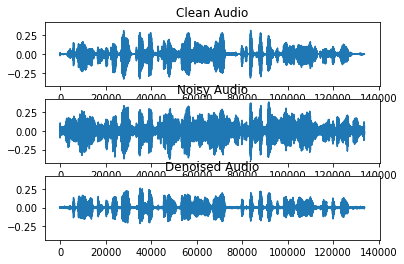

In [57]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFullyConvolutional)
ax3.set_title("Denoised Audio")